## Download omics dataset

The data can be downloaded from the Gene Ontology Omnibus which can be accessed via this link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE183310. The data chosen for this exploration is single nucleus RNA sequencing data. Single nucelus data is similar to single cell data in that it is sequenced to generate a gene expression profile however, instead of the entire cell being sequenced, just the nucleus is sequenced. This is normally done when isolating each cells gene expression profile is difficult or cannot be done. The expression data for nuclei of cells in the Pulmonary Vein were chosen. The wildtype gene expression profile will be compared to the mutant gene expression profile.

In [1]:
%%bash
# downloading wildtype gene expression data
cwd=`pwd`
mkdir -p $cwd/data/GSE183310_snRNA-Pitx2-PV-WT/ 
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-WT_matrix.mtx.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-WT/matrix.mtx.gz
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-WT_features.tsv.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-WT/features.tsv.gz
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-WT_barcodes.tsv.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-WT/barcodes.tsv.gz

In [3]:
%%bash
# downloading mutant gene expression data
cwd=`pwd`
mkdir -p $cwd/data/GSE183310_snRNA-Pitx2-PV-MUT/ 
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-MUT_matrix.mtx.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-MUT/matrix.mtx.gz
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-MUT_features.tsv.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-MUT/features.tsv.gz
wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183310/suppl/GSE183310_snRNA-Pitx2-PV-MUT_barcodes.tsv.gz -O $cwd/data/GSE183310_snRNA-Pitx2-PV-MUT/barcodes.tsv.gz

The data downloaded is in the conventional 10x matrix format, traditionally produced by alignment software like Cellranger or Starsolo. It consists of a gene expression matrix (matrix.mtx.gz) containing the expression value for each nuclei for each gene, a barcodes tab-separated file (barcodes.tsv.gz) containing a list of barcodes, each of which uniquely represents a nucleus of a cell, and a features tab-separated file (features.tsv.gz) which contains a list of genes.

## Processing the data
#### using N-dimensional arrays

Scanpy is a tool that can be used on 10X data for various analyses, such as identifying the most expressed genes or clustering the data etc. The exploration done with Scanpy uses the tutorials available here: https://scanpy-tutorials.readthedocs.io/en/latest/index.html

In [4]:
import scanpy as sc

In [5]:
mut_adata = sc.read_10x_mtx("data/GSE183310_snRNA-Pitx2-PV-MUT/", var_names='gene_symbols', cache=True)

In [7]:
wt_adata = sc.read_10x_mtx("data/GSE183310_snRNA-Pitx2-PV-WT/", var_names='gene_symbols', cache=True)

Scanpy builds an anndata object from the 10X sequencing input data. The anndata object consists of 4 main components. Adata.X is a scipy sparse csr matrix of the expression data. Adata.obs is a pandas dataframe containing all the data regarding each cell. Adata.var is a pandas dataframe containing all the data regarding each gene. Each barcode represents one row in the matrix while each gene represents each column. There is also adata.uns which is an unstructured object containing all additional metadata.

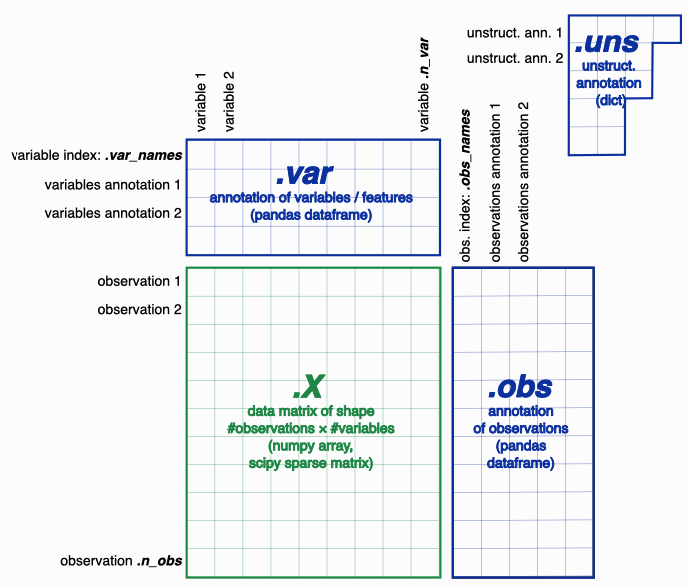

Image taken from: https://cellgeni.readthedocs.io/en/latest/visualisations.html

As gene symbols were used to make the column names, a function that makes each gene name unique is needed in order to differentiate the rownames in the .var pandas dataframe

In [14]:
mut_adata.var_names_make_unique()
wt_adata.var_names_make_unique()

Some basic filtering needs to be done in order to ensure only high quality nuclei and genes remain. So each gene in less than 3 nuclei and each nuceli with less than 200 genes expressed are filtered out.

In [15]:
sc.pp.filter_cells(mut_adata, min_genes=200)
sc.pp.filter_genes(mut_adata, min_cells=3)

In [16]:
sc.pp.filter_cells(wt_adata, min_genes=200)
sc.pp.filter_genes(wt_adata, min_cells=3)

Comparing which genes are mostly highly expressed in the wildtype and the mutant data shows some interesting results. Both have Malat1 as the most highly expressed gene followed by a mitochondrial gene called Col1. One interesting different is that Nppa is more highly expressed in the wildtype in relation to other genes compared to the mutant. Gm42418 seems to be alot more highly expressed in the mutant compared to the wildtype.

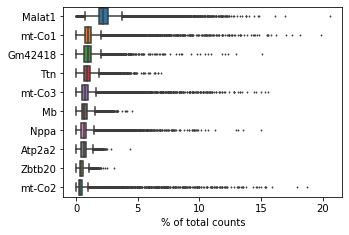

In [18]:
sc.pl.highest_expr_genes(mut_adata, n_top=10)

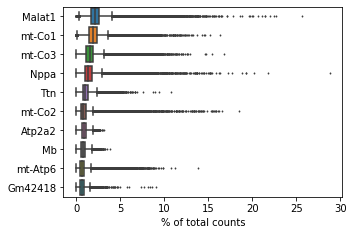

In [19]:
sc.pl.highest_expr_genes(wt_adata, n_top=10)

I will take a list of the top 10 expressed genes in the mutant data, excluding the 3 mitochondrial genes and save a subset of the mutant anndata object containing only these genes. This will be for coexpression analysis done later.

In [20]:
top_genes = ["Malat1", "Gm42418", "Ttn", "Mb", "Nppa", "Atp2a2", "Zbtb20"]

In [21]:
top_mut_adata = mut_adata[:, top_genes]

In [26]:
!mkdir -p results

In [52]:
#wd=os.getcwd()
top_mut_adata.write("results/top_mut_expression.h5ad")

Each dataset will be evaluated for quality using built in quality control metrics.

In [28]:
sc.pp.calculate_qc_metrics(mut_adata, percent_top=None, log1p=False, inplace=True)

In [29]:
sc.pp.calculate_qc_metrics(wt_adata, percent_top=None, log1p=False, inplace=True)

2 metrics that are used alot are "n_genes_by_counts" and "total_counts". Some biological terms are needed to explain the next part. In sequencing, a read is a fragment of DNA that is sequenced. A count is the number of reads that overlap at a genomic region. So "n_genes_by_counts" refers to the number of genes with atleast 1 count in a nucleus. Meanwhile, "total_counts" refers to the total number of counts in each nucleus

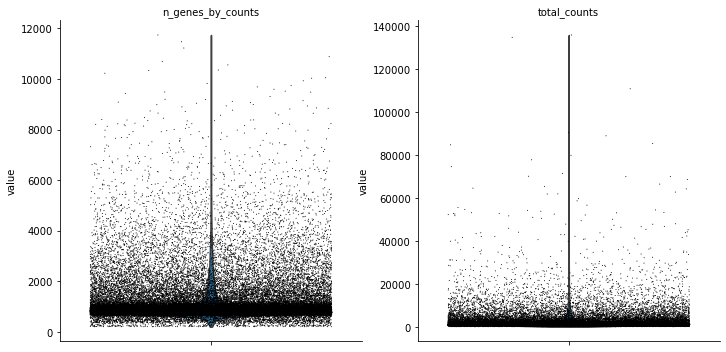

In [31]:
sc.pl.violin(mut_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

... storing 'feature_types' as categorical


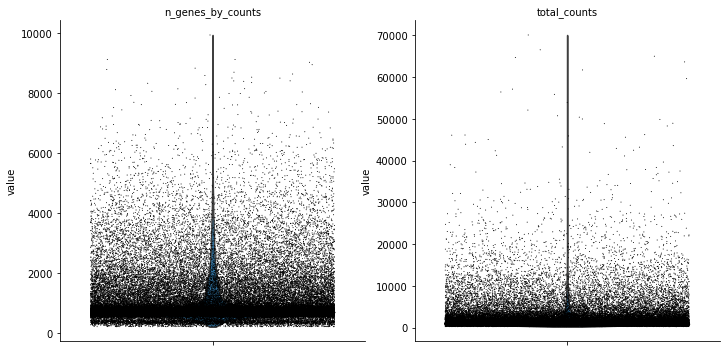

In [32]:
sc.pl.violin(wt_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

As you can see, the wildtype and mutant have a similar number of nuclei with atleast one count but the total counts for each nuclei is significantly less for the widltype data

Lets filter the anndata objects and normalise their expression so that expression between cells can be compared. The expression will then be logarithimised so that variation can be seen easier

In [39]:
mut_adata = mut_adata[mut_adata.obs.n_genes_by_counts < 2500, :]
sc.pp.normalize_total(mut_adata, target_sum=1e4)
sc.pp.log1p(mut_adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [40]:
wt_adata = wt_adata[wt_adata.obs.n_genes_by_counts < 2500, :]
sc.pp.normalize_total(wt_adata, target_sum=1e4)
sc.pp.log1p(wt_adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Calculating which genes are highly variable between nuclei can help identify biomarkers for particular cell types

In [41]:
sc.pp.highly_variable_genes(mut_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [42]:
sc.pp.highly_variable_genes(wt_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

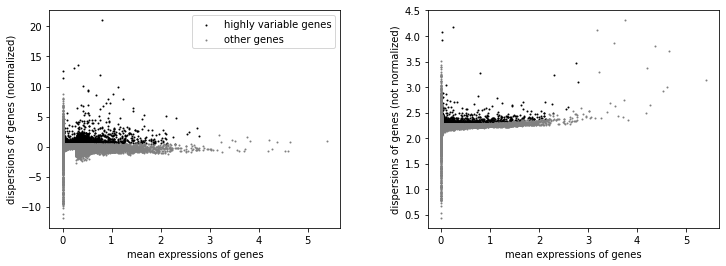

In [43]:
sc.pl.highly_variable_genes(mut_adata)

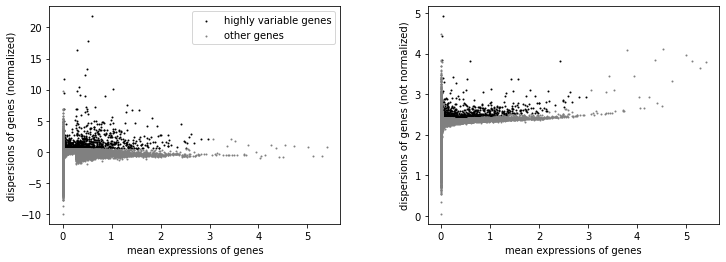

In [44]:
sc.pl.highly_variable_genes(wt_adata)

Looking at the dispersion of the normalised gene expression for both wildtype and mutant, the dispersion of genes seems to be fairly similar howeber the mutant seems to only have one gene significantly differently dispersed.

The next steps involves regressing out and scaling the data to adjust for "total_counts" that will allow for better comparison of the data later on. In order to do this, the current state of the objected (normalised and logarithimised before manipulation) is saved to the .raw attribute of the object.

In [45]:
mut_adata.raw = mut_adata
wt_adata.raw = wt_adata

In [46]:
sc.pp.regress_out(mut_adata, 'total_counts')

In [47]:
sc.pp.regress_out(wt_adata, 'total_counts')

In [48]:
sc.pp.scale(mut_adata, max_value=10)

In [49]:
sc.pp.scale(wt_adata, max_value=10)

There is so much variation within gene expression that trying to calculate the cause of variance can be difficult. To aid this, variance is combined into principal components where each components tries to account for as much variance as possible in order for data comparison. This is done used principal component analysis.

In [50]:
sc.tl.pca(mut_adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [51]:
sc.tl.pca(wt_adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


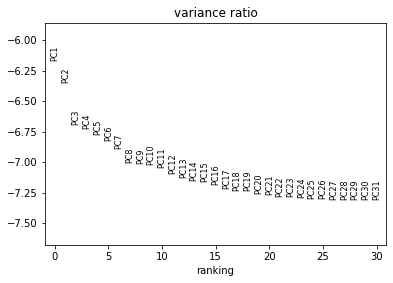

In [53]:
sc.pl.pca_variance_ratio(mut_adata, log=True)

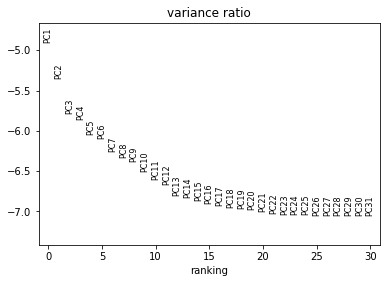

In [54]:
sc.pl.pca_variance_ratio(wt_adata, log=True)

PCA shows that the top 2 components in both the wildtype and mutant datasets incapsulate the majority of variance, however in the wildtype data the remaining principle components equate for more variance compared to the top 2 components than in the mutant. The wildtype also has a negative exponential relationship between all the components while the mutant has a less significant pattern. This implies that a mutation causes a change in the mutant which accounts for significant variation, and this is captured in the top two components.

The nuclei are going to be clustered to see which nuclei are more similar and which are more different. Clustering analysis allows us to see if each cluster relates to a particular cell type and then if that cell type has potential biomarkers. In order to do this, a nearest nieghbour graph needs to be generated for the data.

In [55]:
sc.pp.neighbors(mut_adata)

In [56]:
sc.pp.neighbors(wt_adata)

In order to visualise this graph, dimensionality reduction must occur. PCA does dimensionality reduction however this needs to be embedded. UMAP takes the nuclei that are represented in multidimensional space (their position is based on the values on each principle component, nearer nueclei are more similar) and embeds that into 2 dimensions to be visualised. This can also be done with tsne however that has a bias in that each principal component variance is calculated based on the previous component which can lead to bias

In [57]:
sc.tl.umap(mut_adata)

In [58]:
sc.tl.umap(wt_adata)

Clustering will be perfomed using the Leiden algorithm. This has become the de facto standard for clustering in recent years and has good scanpy integration. Methods such as Louvain can also be used here.

In [59]:
sc.tl.leiden(mut_adata)

In [60]:
sc.tl.leiden(wt_adata)

In [4]:
import pandas as pd

In [83]:
mut_leiden = pd.DataFrame(mut_adata.obs['leiden'])
len(mut_leiden.leiden.unique())

92

In [82]:
wt_leiden = pd.DataFrame(wt_adata.obs['leiden'])
len(wt_leiden.leiden.unique())

73

The mutant data has around 20 more clusters than the wildtype. This could be due to a mutation dramatically effecting cells so that cells of the same type that now have a mutation no longer seem similar to Leiden

Now that each cluster is found. The top marker genes for each cluster can be calculated. Various stastical tests such as Wilcoxon-rank or logistic regression can be used for this. Scanpy recommends t-test as the default so that will be used.

In [61]:
sc.tl.rank_genes_groups(mut_adata, 'leiden', method='t-test')

In [62]:
sc.tl.rank_genes_groups(wt_adata, 'leiden', method='t-test')

Due to the number of clusters, I will not visualise each clusters top genes compared to the rest of the clusters. Instead I will demonstrate with cluster 0, the first cluster. This will visualise if there are any potential biomarkers based on what genes are significantly expressed. 

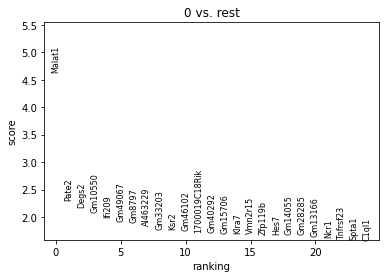

In [86]:
sc.pl.rank_genes_groups(mut_adata, n_genes=25, groups='0')

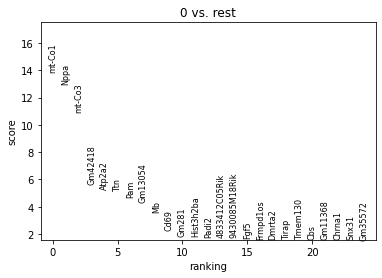

In [87]:
sc.pl.rank_genes_groups(wt_adata, n_genes=25, groups='0')

In the mutant data, cluster 0 has one signficantly expressed gene: Malat1. However, if you remember back to when we look back at the top expressed genes this was the most highly expressed gene in both datasets. Moreover, cluster 0 tends to be the biggest cluster so it is no surprise this gene is a marker. What is interesting is that it is the only significantly expressed gene compared to the wildtype cluster 0 which has 3. This implies that either Malat1 is overexpressed compared to the wild type or other genes may be suppressed in the mutant.

In [89]:
mut_adata.write("results/mut_explored.h5ad")

In [90]:
wt_adata.write("results/wt_explored.h5ad")

## Identify a model and use ODEs to model it

The model chosen is of the atriobentricular node. The AVN is a structure that delays the electrical impulse generated from the SAN reaching the ventricals so that the atria empty before the ventricals contract, allowing all the blood to pass through the heart. This model represents the action potential for single artio-nodal cells. 

In [92]:
import sbmltoodepy

In [2]:
#!wget -q https://www.ebi.ac.uk/biomodels/model/download/MODEL1006230082.2?filename=MODEL1006230082_urn.xml -O data/MODEL1006230082_urn.xml

In [3]:
#sbmltoodepy.ParseAndCreateModel("data/MODEL1006230082_urn.xml",outputFilePath = "AVNfile.py", className = "AVNmodel")

In [107]:
from AVNfile import AVNmodel
membrane_model = AVNmodel()

The following ordinal differential equation (ODE) shows how the voltage of the an atrio-nodel cell's membrane changes over time. As can be seen when plotted below this follows the trajectory of an expected action potential. Starting at a slightly negative value, decreasing to -74.5V which is the expected voltage in which voltage gated channels open. The voltage then rapidly increasing as Calcium ions pass through the membrane. The voltage eventually platoes when the voltage gets less negative enough that the gates close. Then overtime the as the Calcium ions are used the voltage will drop back to its original value, starting the cycle again.

In [115]:
import numpy as np

In [108]:
membrane_times = np.zeros(101)
membrane_times[0] = membrane_model.time
membrane_voltages = np.zeros(101)
membrane_voltages[0] = membrane_model.p['V_membrane'].value
membrane_timeinterval = 1
for i in range(100):
    membrane_model.RunSimulation(membrane_timeinterval)
    membrane_times[i+1] = membrane_model.time
    membrane_voltages[i+1] = membrane_model.p['V_membrane'].value

In [95]:
import matplotlib.pyplot as plt

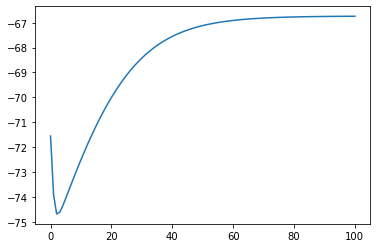

In [110]:
plt.plot(membrane_times, membrane_voltages)

In [111]:
ca_model = AVNmodel()

The following Ordinal Differential Equation (ODE) shows the uptake of Calcium ions over time. At the beginning, the uptake is very high as the voltage gated channels open and diffusion occurs across the membrane. However, this movement of position ions causes less ions to move through by diffusion as there is no longer a concentration gradient across the membrane. Frutheremore, the voltage difference across the membrane decreases as positive ions move across it causing the ion channels to close leading to no further movement of ions.

In [113]:
ca_times = np.zeros(101)
ca_times[0] = ca_model.time
ca_voltages = np.zeros(101)
ca_voltages[0] = ca_model.p['Ca_up'].value
ca_timeinterval = 1
for i in range(100):
    ca_model.RunSimulation(ca_timeinterval)
    ca_times[i+1] = ca_model.time
    ca_voltages[i+1] = ca_model.p['Ca_up'].value

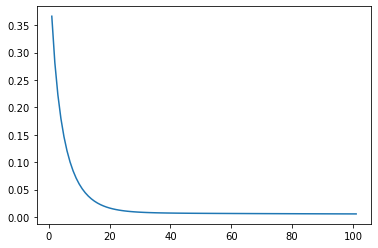

In [114]:
plt.plot(ca_times, ca_voltages)

## Generate a Network

In order to generate a network, we need to produce a list of edges between nodes. The nodes in this case will be different nuclei represented by barcodes. Using a separate R script that can be executed in this notebook, we will be able to produce this file using the top expressed mutant data genes .h5ad file generated earlier. The reason why the this h5ad file is used is due to resources. Generating an adjacency matrix is computationally heavy and so a smaller matrix such as one generated from this file can be produced rather quickly without too much resource use.

In [1]:
!Rscript generate-node-file.R

In [2]:
# importing networkx
import networkx as nx

# importing matplotlib.pyplot
import matplotlib.pyplot as plt

In [5]:
top_mut_edges=pd.read_csv("results/top_mut_edges.txt", sep="\t")

In [14]:
top_mut_edges.shape

(931866194, 6)

To illustrate a pertubation within a network first I will filter a the edge dataframe for the top 50 results for a specific nuclei. This is done as there are 931million rows in the dataframe connecting various nueclei. The significance of a pertubation can be shown using only a subset of these

In [7]:
top_mut_from = top_mut_edges[top_mut_edges.fromNode == 'AAACCCAAGACGCTCC-1']
top_mut_from = top_mut_from.iloc[:50, ]

In [8]:
G_from = nx.Graph()

G_from = nx.from_pandas_edgelist(top_mut_from, "fromNode", "toNode", edge_attr="weight")

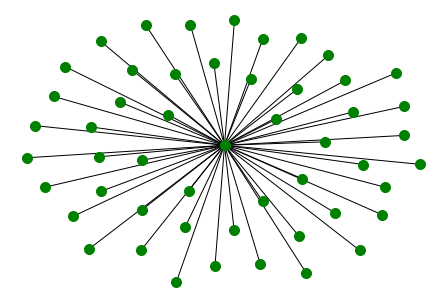

In [10]:
nx.draw(G_from, node_color='green', node_size=100)

As you can see the barcode "AAACCCAAGACGCTCC-1" is at the centre of many connections. So if a pertubation were to destroy this hub it could have huge ramifications across a network.

To illustrate this further. Take the 10 nodes that "AAACCCAAGACGCTCC-1" is attached to.

In [27]:
to_nodes = list(top_mut_from.toNode)[:11]

In [29]:
top_mut_to = top_mut_edges[top_mut_edges.toNode.isin(to_nodes)]

In [30]:
top_mut_to

,fromNode,toNode,weight,direction,fromAltName,toAltName
1,AAACCCAAGAAGGGAT-1,AAACCCAAGAGAACCC-1,0.539296,undirected,NaN,NaN
2,AAACCCAAGAAGGGAT-1,AAACCCAAGCATCAGG-1,0.585312,undirected,NaN,NaN
3,AAACCCAAGAAGGGAT-1,AAACCCAAGGCGAAGG-1,0.974831,undirected,NaN,NaN
4,AAACCCAAGAAGGGAT-1,AAACCCAAGGGAGGAC-1,0.794944,undirected,NaN,NaN
5,AAACCCAAGAAGGGAT-1,AAACCCAAGGGCAGAG-1,0.702812,undirected,NaN,NaN
...,...,...,...,...,...,...
386008,AAACCCAAGGGTTTCT-1,AAACCCAAGTGAGTGC-1,0.790842,undirected,NaN,NaN
386009,AAACCCAAGGGTTTCT-1,AAACCCAAGTTACTCG-1,0.663544,undirected,NaN,NaN
421451,AAACCCAAGTCCGTCG-1,AAACCCAAGTGAGTGC-1,0.558077,undirected,NaN,NaN
421452,AAACCCAAGTCCGTCG-1,AAACCCAAGTTACTCG-1,0.648488,undirected,NaN,NaN


As demonstrated above, the top 10 nodes connected to the original "AAACCCAAGACGCTCC-1" node have a further 68 connections. When you consider we deliberately took small subsets of nodes to illustrate this, it shows just how interconnect the different cells are and so how damaging a pertubation that damages a hub can be. 

In [32]:
G_to = nx.Graph()

G_to = nx.from_pandas_edgelist(top_mut_to, "fromNode", "toNode", edge_attr="weight")

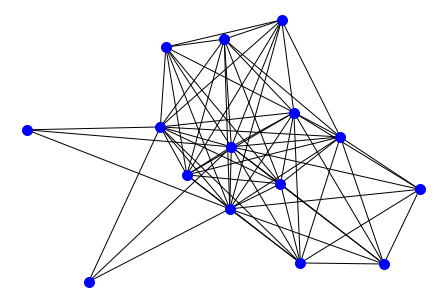

In [33]:
nx.draw(G_to, node_color='blue', node_size=100)

Looking at the network generated, you can see just how interconnected all the different nodes are. This further cements the idea that if one node goes down, it can have ramifications across a network if that node is well connected or even worse a hub